In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rich import print
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor, HistGradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
import joblib

import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings('ignore')

## Model Pipeline


Recap on preprocessing/feature engineering done:

- Ordinal encoding
- Scale numerical data
- drop uninformative features
- principle component analysis
- KMeans clustering
- Target encoding
- One-hot encoding
- feature creationdd


Can now build a variety of regression models useful for predicting house prices

## Load data


In [76]:
# load data
dir = Path().resolve().parents[0] / "data" / "final"

In [77]:
train_path = dir / "fin_train.pkl"
test_path = dir / "fin_test.pkl"

train_df = pd.read_pickle(train_path)
X_test = pd.read_pickle(test_path)

In [78]:
train_df.head(2)

,LotFrontage,LotArea,LotShape,Utilities,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior2nd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,Fence,SalePrice,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PC1,cluster,GrLivArea,AreaRoomRatio,GarageAreaPerCar,BathBedroomRatio,LandPropertyRatio
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,3.0,0.0,-0.211518,6.0,4.0,1.050994,0.878668,0.143911,0.514104,2.0,4.0,2.0,4.0,3.0,2.0,0.575425,6.0,-0.944591,-0.459303,0.0,1.0,5.0,-0.793434,1.161852,1.107810,0.789741,1.227585,0.163779,-0.211454,2.0,0.912210,6.0,-0.951226,3.0,1.017598,2.0,0.311725,0.351000,5.0,5.0,2.0,-0.752176,0.216503,-0.359325,-0.270208,4.0,208500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50523,4,0.370333,0.405974,1.125995,4.821985,-0.861431
2,0.460320,-0.091886,3.0,0.0,-0.278367,5.0,7.0,0.156734,-0.429577,-0.323985,-0.570750,3.0,4.0,2.0,4.0,1.0,0.0,1.171992,6.0,-0.641228,0.466465,0.0,1.0,5.0,0.257140,-0.795163,-0.819964,0.789741,-0.761621,0.163779,-0.211454,3.0,-0.318683,6.0,0.600495,5.0,-0.107927,2.0,0.311725,-0.060731,5.0,5.0,2.0,1.626195,-0.704483,-0.359325,-0.270208,4.0,181500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.35290,0,-0.482512,1.514080,-0.194823,4.821985,-0.335127


In [79]:
# split data
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"].copy()
y = np.log1p(y)

In [80]:
train_cols = X.columns.tolist()
test_cols = X_test.columns.tolist()


train_col_drop = [col for col in train_cols if col not in test_cols]
test_col_drop = [col for col in test_cols if col not in train_cols]

X = X.drop(columns=train_col_drop)
X_test = X_test.drop(columns=test_col_drop)

## Model comparison pipeline


Create functions that will help evaluate the our models:
- use K-Fold cross validation 
- score each model using RMSLE
- visualise and contrast each model's performance across each K-Fold

In [81]:
def cross_val_model(model, X, y, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42).get_n_splits(X.values)
    scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")
    scores = np.sqrt(scores)

    print(
        f"RMSLE: {scores}\n Mean: {scores.mean()}\n Standard deviation: {scores.std()}"
    )

    return scores.mean(), scores

In [82]:
def model_eval_pipeline(model_pipe, X, y):
    model_mean_scores = []
    model_scores = []

    for name, model in model_pipe:
        print(f"Cross-validating {name}")

        # return RMSLE scores
        mean_score, scores = cross_val_model(model, X, y)

        # append results
        model_mean_scores.append(mean_score)
        model_scores.append({name: scores})

    # get the best model
    smallest_score = min(model_mean_scores)
    index_pos = model_mean_scores.index(smallest_score)
    model = model_pipe[index_pos]

    print(f"Best model: {model[0]} with RMSLE: {smallest_score}")

    return model[1], model_scores

Build each model

In [83]:
gbr = GradientBoostingRegressor(random_state=42, loss="huber")
kr = KernelRidge(alpha=0.6, kernel="polynomial", degree=2, coef0=2.5)
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=42))
xgb = XGBRegressor(random_state=42)
hgb = HistGradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)


stack = StackingRegressor(
    estimators=[
        ("gbr", gbr),
        ("kr", kr),
        ("lasso", lasso),
        ("xgb", xgb),
        ("hgb", hgb),
        ("rf", rf),
    ],
    final_estimator=gbr,
    cv=5,
    n_jobs=-1,
)

The code below takes each model and runs them through the evaluation functions above, allowing us to quickly evaluate the performance of each model before progressing to hyperparameter tuning.

In [84]:
model_names = [
    "Gradient Boosting Regressor",
    "Random Forest Regressor",
    "Hist Gradient Boosting Regressor",
    "XGBoost Regressor",
    "Kernel Ridge Regressor",
    "Lasso Regressor",
]

models = [
    gbr,
    rf,
    hgb,
    xgb,
    kr,
    lasso
]

model_pipe = list(zip(model_names, models))

best_model, model_scores = model_eval_pipeline(model_pipe, X, y)

# output best model
joblib.dump(best_model, Path().cwd().parent / "models" / "base" / "gbr_best_model.pkl")

best_model

Cross-validating Gradient Boosting Regressor

RMSLE: [0.11766098 0.14008409 0.13791712 0.12473277 0.12887681]
 Mean: 0.12985435460191536
 Standard deviation: 0.008312885279518938

Cross-validating Random Forest Regressor

RMSLE: [0.13109872 0.16218708 0.15380668 0.14451925 0.1367963 ]
 Mean: 0.14568160512814585
 Standard deviation: 0.011237509418696565

Cross-validating Hist Gradient Boosting Regressor

RMSLE: [0.11998554 0.14569952 0.13415404 0.12765721 0.13234285]
 Mean: 0.13196783072053658
 Standard deviation: 0.008433698852347628

Cross-validating XGBoost Regressor

RMSLE: [0.12986212 0.16094546 0.16237623 0.1254615  0.14109518]
 Mean: 0.14394809849362214
 Standard deviation: 0.015341541402700618

Cross-validating Kernel Ridge Regressor

RMSLE: [0.1261452  0.18576422 0.13612904 0.11851934 0.13748989]
 Mean: 0.14080953822085726
 Standard deviation: 0.02351912701746946

Cross-validating Lasso Regressor

RMSLE: [0.12689613 0.15773815 0.13482594 0.12846154 0.19785416]
 Mean: 0.14915518597946478
 Standard deviation: 0.026736780022282452

Best model: Gradient Boosting Regressor with RMSLE: 0.12985435460191536

GradientBoostingRegressor(loss='huber', random_state=42)

Model rankings based on average RMSLE score:
- Gradient Boosting 
- Hist Gradient Boosting 
- Kernel Ridge 
- XGBoost
- Random Forest
- Lasso

In [85]:
def model_comp_plot(data: list[dict[str, int]]) -> None:
    """Plot the model performance for each K-fold.

    Args:
        data (list[dict[str, int]]): list containing MAE scores for each K-fold
    """
    # unpack model scores
    scores = {list(item.keys())[0]: item[list(item.keys())[0]] for item in data}

    # Create a Pandas DataFrame
    df = pd.DataFrame(scores)
    df["K-fold"] = df.index + 1
    df = df.melt(id_vars=["K-fold"], var_name="Model", value_name="RMSLE")

    # plot
    sns.lineplot(data=df, x="K-fold", y="RMSLE", hue="Model")
    plt.title("RMSLE for each K-fold - Model Comparison")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

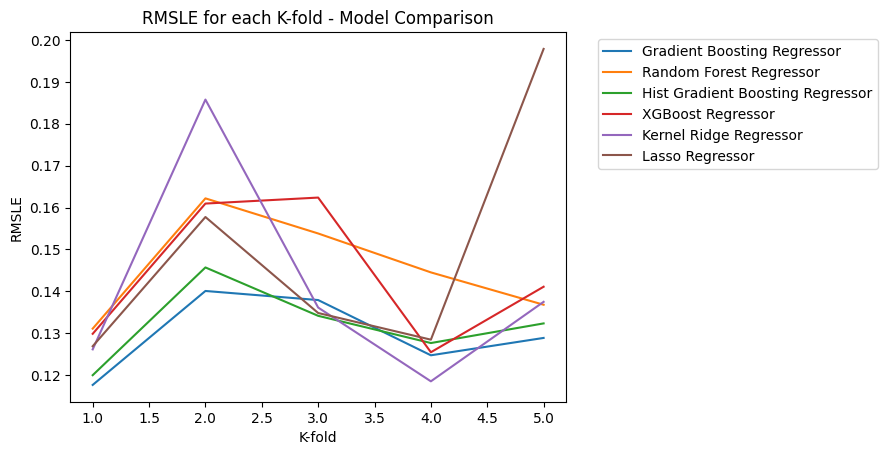

In [86]:
model_comp_plot(model_scores)

In [87]:
def grid_search_tuning(model, params, X, y):
    grid_search = GridSearchCV(
        model,
        param_grid=params,
        cv=10,
        scoring="neg_mean_squared_log_error",
        n_jobs=-1,
    )
    grid_search.fit(X, y)

    return grid_search.best_estimator_, grid_search.cv_results_

In [112]:
def random_search_tuning(model, params, X, y):
    random_search = RandomizedSearchCV(
        model,
        param_distributions=params,
        # n_iter=100,
        cv=10,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
    )
    random_search.fit(X, y)

    return random_search.best_estimator_, random_search.cv_results_

In [113]:
def hyperparameter_tuning_results(cv_results: dict[str, np.ndarray]) -> list:
    return [
        (-mean_score, params)
        for mean_score, params in zip(
            cv_results["mean_test_score"], cv_results["params"]
        )
    ]

In [114]:
grid_parameters = {
    "loss": ["ls", "lad", "huber", "quantile"],
    "learning_rate": [0.01, 0.05, 0.1, 0.5],
    "n_estimators": [100, 500, 1000, 2000],
    "max_depth": [3, 5, 10, 15],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "subsample": [0.5, 0.75, 1.0],
}

In [116]:
random_params = {
    "n_estimators": stats.randint(50, 200),
    "max_depth": stats.randint(2, 6),
    'n_iter_no_change': stats.randint(5, 20),
    "learning_rate": [0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.49]
}

In [117]:
best_estimator, cv_results = random_search_tuning(best_model, random_params, X, y)

rmsle_scores = hyperparameter_tuning_results(cv_results)

print(rmsle_scores)

[
    (0.0244162562011364, {'learning_rate': 0.49, 'max_depth': 5, 'n_estimators': 87, 'n_iter_no_change': 7}),
    (0.017077995318476032, {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 134, 'n_iter_no_change': 14}),
    (0.031376002816966356, {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 187, 'n_iter_no_change': 6}),
    (0.02440772878818073, {'learning_rate': 0.49, 'max_depth': 5, 'n_estimators': 81, 'n_iter_no_change': 17}),
    (0.018420834534310017, {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 195, 'n_iter_no_change': 11}),
    (0.023130224862064633, {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 63, 'n_iter_no_change': 16}),
    (0.018717942779606235, {'learning_rate': 0.49, 'max_depth': 2, 'n_estimators': 119, 'n_iter_no_change': 12}),
    (0.018559754345863922, {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 170, 'n_iter_no_change': 11}),
    (0.018099920808940097, {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 185, 'n_iter_no_change': 8}),
    (0.01825095816180982, {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 146, 'n_iter_no_change': 5})
]

In [118]:
# output tuned model
joblib.dump(best_estimator, Path().cwd().parent / "models" / "tuned" / "gbr_tuned_model.pkl")

best_estimator

GradientBoostingRegressor(loss='huber', max_depth=4, n_estimators=134,
                          n_iter_no_change=14, random_state=42)

## Feature Importances


In [119]:
feature_importance = best_estimator.feature_importances_
importance_df = pd.DataFrame(
    {"features": X.columns, "importance": feature_importance}
).sort_values(by="importance", ascending=False)

In [120]:
importance_df

,features,importance
71,PC1,0.569129
5,OverallQual,0.206546
4,Neighborhood,0.044265
73,GrLivArea,0.037013
8,YearRemodAdd,0.019385
...,...,...
63,GarageType_None,0.000000
50,SaleType_Con,0.000000
59,GarageType_Basment,0.000000
57,GarageType_2Types,0.000000


In [121]:
def feature_importance_plot(data: pd.DataFrame):
    # Creating a bar chart
    plt.figure(figsize=(6, 6))
    sns.barplot(x="importance", y="features", data=data[data["importance"] != 0])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importance")
    plt.grid(axis="x")

    # Display the chart
    plt.show()

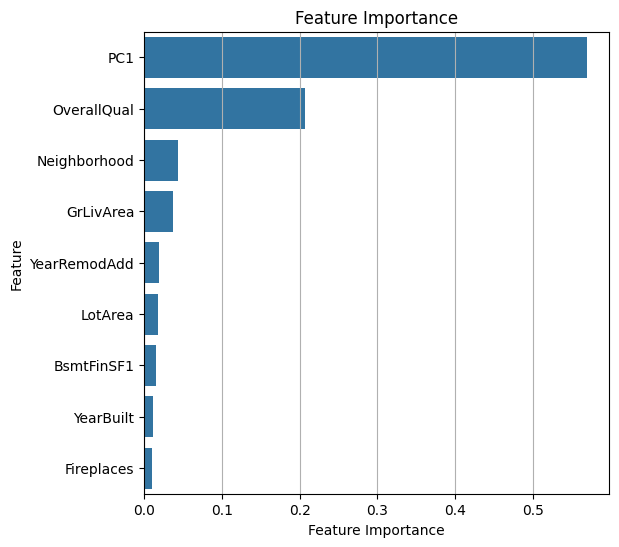

In [122]:
feature_importance_plot(importance_df.loc[importance_df["importance"] > 0.01])

## Predict test set


Tuned model

In [123]:
final_pred = best_estimator.predict(X_test)

In [124]:
output = pd.DataFrame({"Id": X_test.index, "SalePrice": final_pred})

In [125]:
output_path = Path().cwd().parent / "output" / "tuned_gbr_results.csv"
output.to_csv(output_path, index=False)

In [126]:
output.head(2)

,Id,SalePrice
0,1461,11.794273
1,1462,11.953390


Base model

The initial tuned result score (0.158) indicates there is suspected overfitting in the model, try with base GBR model and see what the result is

In [127]:
best_model.fit(X, y)

GradientBoostingRegressor(loss='huber', random_state=42)

In [128]:
y_pred = np.exp(best_model.predict(X_test))

In [129]:
base_output = pd.DataFrame({"Id": X_test.index, "SalePrice": y_pred})

In [130]:
output_path = Path().cwd().parent / "output" / "base_gbr_results.csv"
base_output.to_csv(output_path, index=False)

## Stacking

I want to stack the base models together to see if they produce a more accurate result

In [131]:
stacking_reg = StackingRegressor(
    estimators=[
        ("gbr", XGBRegressor()),
        ("rfr", RandomForestRegressor(random_state=42)),
    ],
    final_estimator=best_model,
    cv=5,
)

In [132]:
stacking_reg.fit(X, y)

StackingRegressor(cv=5,
                  estimators=[('gbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learni...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('rfr', RandomForestRegressor(random_state=42))],
                  final_estimator=GradientBoostingRegressor(loss='huber',
                                                            random_state=42))

In [136]:
stacked_pred = np.exp(stacking_reg.predict(X_test))

In [137]:
stacked_output = pd.DataFrame({"Id": X_test.index, "SalePrice": stacked_pred})
stacked_output

,Id,SalePrice
0,1461,141617.302219
1,1462,168452.206846
2,1463,177209.576649
3,1464,190937.460682
4,1465,199377.294043
...,...,...
1454,2915,87285.408830
1455,2916,90209.956536
1456,2917,177209.576649
1457,2918,111882.832962


In [135]:
output_path = Path().cwd().parent / "output" / "stacked_results.csv"
stacked_output.to_csv(output_path, index=False)